# Create DataFrame

In [1]:
# Configuration

# NAME_EVALUATION = 'mean-err-n-sources'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-04*.txt'  # 1st trials, original speech samples

# NAME_EVALUATION = 'mean-err-n-sources-sample3and5exchanged'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-11*.txt'  # 2nd trials, rearranged speech samples

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.0'
# NAME_FOLDER = "{}sources-rnd"
# NAME_DATA_FILES = '2017-*results.txt'  # 3rd trials, BASE

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.3'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.3T60*results.txt'  # 4th trials, T60=0.3

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=5'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*5em_results.txt'  # 5th trials, T60=0.6, em=5

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=10'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*10em_results.txt'  # 6th trials, T60=0.6, em=10

# NAME_EVALUATION = 'mean-err-n-sources-rnd-estimates'
# NAME_FOLDER = "{}sources-rnd-estimates"
# NAME_DATA_FILES = '*results.txt'  # 7th trials, random estimates (benchmark)

EXPORT_LATEX = False

In [2]:
%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

pd.set_option('display.precision',3)

PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

NAME_FOLDER = "fixed-em-iterations-5"
NAME_EVALUATION = NAME_FOLDER
NAME_DATA_FILES = '*results.txt'
NAME_DATAFRAME = NAME_EVALUATION+'.pkl'

NAME_SCATTER_PLOT = NAME_EVALUATION+'-scatter.tex'
NAME_BOX_PLOT = NAME_EVALUATION+'-box.tex'
NAME_BAR_PLOT = NAME_EVALUATION+'-bar.tex'
NAME_SUMMARY_TABLE = NAME_EVALUATION+'-summary.tex'
NAME_PERFECT_MATCHES_PLOT = NAME_EVALUATION+'-perfect-matches-bar.tex'
PATH_SCATTER_PLOT = path.join(PATH_LATEX_PLOTS, NAME_SCATTER_PLOT)
PATH_BOX_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BOX_PLOT)
PATH_BAR_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BAR_PLOT)
PATH_LATEX_SUMMARY_TABLE = path.join(PATH_LATEX_TABLES, NAME_SUMMARY_TABLE)

lms_red = (204/255, 53/255, 56/255)

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)

def adjust_y_axis(step_size, digits=0, min=None):
    start, end = plt.axes().get_ylim()
    if min==None: min=start
    plt.yticks(np.arange(min, round(end+step_size, digits), step_size))

def style_boxplot(boxplots, fig=None, axes=None):
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not fig: fig = boxplots[0][0].ax.get_figure()
    if not axes: axes = [boxplots[0][0].ax]
    for bp in boxplots:
        for key in bp[0].lines.keys():
            for item in bp[0].lines[key]:
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(lms_red)
                    item.set_markersize(7)
                if key=="medians":
                    item.set_color(lms_red)
                    item.set_linewidth(3)
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                else:
                    item.set_color(lms_red)
    if axes:
        for ax in axes:
            ax.set_title("")
            ax.set_xlabel("number of sources")
            ax.set_ylabel("mean localisation error (m)")
            ax.grid(axis="x")
    if fig:
        fig.suptitle('')

def parse_parameters(fname):
    done=False
    s=0
    ret = {}
    while not done:
        i = fname.find("_", s)
        i2 = fname.find("_", i+1)
        s=i2
        if i < 0 or i2 < 0:
            done=True
            break
        else:
            fname_slice = fname[i+1:i2]
            name, value = fname_slice.split("=", 1)
            ret[name]=value
    return ret
        
def matlab2pandas(dirname=NAME_FOLDER, filename=NAME_DATA_FILES, save_to=None):
    files = glob.glob(path.join(PATH_ROOT,dirname,filename))
    dfs = []
    for f in files:
        # look at filename
        fname = f.split(sep="/")[-1]
        params = parse_parameters(fname)
        n_sources = int(params["s"])
        # prepare DataFrame
        df = pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float)
        df.drop(df.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
        df.columns = get_col_names(n_sources)
        df.index = ["t{}".format(i+1) for i in range(len(df))]
        for key, value in params.items():
            df[key] = value
        dfs.append(df)
    
    df = pd.concat(dfs)
    df.rename(columns={'s':'n_sources'}, inplace=True)
    df["err_mean"]      = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].mean(axis=1)
    df["err_total"]     = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].sum(axis=1)
    df["perfect_match"] = df["err_total"]<=0.01

    print(dirname.upper()+":")
    summary = df.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'})
    print(summary.transpose(), end='\n\n')

    if save_to: 
        df.to_pickle(save_to+".pkl")

    return df

## Get Data

FIXED-EM-ITERATIONS-5:
n_sources           2       3       4       5       6       7
sample size    50.000  50.000  50.000  40.000  40.000  40.000
err_mean        0.157   0.272   0.364   0.416   0.384   0.428
perfect_match   0.300   0.120   0.000   0.000   0.000   0.025

FIXED-EM-ITERATIONS-10:
n_sources           2       3       4       5      6       7
sample size    50.000  50.000  50.000  50.000  50.00  40.000
err_mean        0.184   0.253   0.423   0.453   0.48   0.549
perfect_match   0.360   0.080   0.020   0.020   0.00   0.000



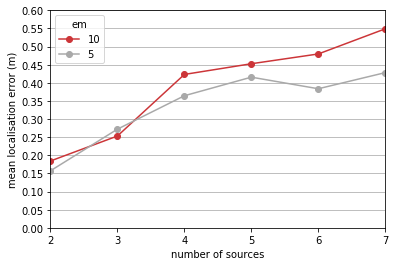

In [3]:
df1 = matlab2pandas(dirname='fixed-em-iterations-5', save_to=path.join(PATH_ROOT, 'fixed-em-iterations-5'))
# ax1 = df1.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).err_mean.plot(kind="line")
df2 = matlab2pandas(dirname='fixed-em-iterations-10', save_to=path.join(PATH_ROOT, 'fixed-em-iterations-10'))
# df2.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).err_mean.plot(kind="line")
df = pd.concat([df1, df2])

dfp = df.pivot_table("err_mean", index="em", columns="n_sources", aggfunc='mean').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
adjust_y_axis(0.05, 2, 0)

In [ ]:
n_sources_range = [1, 2, 3, 4, 5, 6, 7]
results_dict = {}

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(PATH_ROOT,NAME_FOLDER.format(s), NAME_DATA_FILES))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    try:   
        results = pd.concat(dfs)
    except ValueError:
        continue
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    
    # calculate helper columns
    results['n_sources']     = n_sources
    results["err_mean"]      = results.loc[:, "err1":_get_err_col_name(s)[-1]].mean(axis=1)
    results["err_total"]     = results.loc[:, "err1":_get_err_col_name(s)[-1]].sum(axis=1)
    results["perfect_match"] = results["err_total"]<=0.01

try:   
    results = pd.concat(results_dict, ignore_index=True)
except ValueError:
    print("NO DATA FOUND!")

print("SUMMARY:")
summary = results.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'})
print(summary.transpose())

# print("")
# print("COMPLETE DATA:")
# print(results.sample(5))
if EXPORT_RESULTS:
    results.to_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))
if EXPORT_LATEX:
    summary.transpose().to_latex(PATH_LATEX_SUMMARY_TABLE, column_format="rrrrrrr", bold_rows=True)

# Analyse DataFrame

### Plot

In [ ]:
# Scatter Plot
x = pd.to_numeric(results['n_sources'].values)  # without to_numeric(), tikz_save() fails (TypeError: str instead of int)
y = results["err_mean"].values
print()
means = results.groupby(['n_sources']).mean()["err_mean"]
medians = results.groupby(['n_sources']).median()["err_mean"]
plt.scatter(x, y, alpha=0.1, c="gray")
plt.scatter(means.index.values, means.values, alpha=1.0, c=lms_red, marker="o", linewidth="4", label="mean")
plt.scatter(medians.index.values, medians.values, alpha=1.0, c="black", marker="_", linewidth="2", label="median")
plt.xticks(n_sources_range)
adjust_y_axis(step_size=0.5, digits=2, min=0)
plt.grid(True, axis='y')
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
l = plt.legend()
if EXPORT_LATEX:
    tikz_save(PATH_SCATTER_PLOT, show_info=False)

### Examine Outliers

In [ ]:
# print(results[results["err_mean"]>=1].loc[:, "x1":"x2est"])
print(results[results["err_mean"]>=1.5])

# Compare DataFrames

## Load data

In [ ]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-T60*-dataframe.pkl'))
files2 = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-estimates-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")

dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    version = fname[fname.find("rnd-")+4:fname.find("-dataframe")]
    if version=="": version="latest"
    df["version"] = version
    dfs.append(df)

for f in files2:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    df["version"] = "random"
    dfs.append(df)

dfc = pd.concat(dfs, ignore_index=True)
print("\nSUMMARY:")
print(dfc.groupby(by=["version", "n_sources"]).agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'}))

## Mean error

In [ ]:
dfcp = dfc.pivot_table("err_mean", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
print(dfcp)

In [ ]:
# Box Plot
bp = dfc.boxplot('err_mean', by=["n_sources", "version"], return_type='both', figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

### Perfect matches

In [ ]:
dfcp = dfc.pivot_table("perfect_match", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "darkgrey", "lightgray", "black", "darkgrey", "darkgrey"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("perfect matches")
plt.grid(axis="y")
# print(dfcp)

## Effect of em_iterations 

In [ ]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-T60=0.6-em*-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")

dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    T60 = fname[fname.find("T60")+4:fname.find("T60")+7]
    df["T60"] = T60
    em_iterations = fname[fname.find("em=")+3:fname.find("em=")+5]
    if "-" in em_iterations: em_iterations = em_iterations[0]  # if em_iterations is a single digit
    df["em_iterations"] = em_iterations
    dfs.append(df)

dfc = pd.concat(dfs, ignore_index=True)
print("\nSUMMARY:")
print(dfc.groupby(by=["em_iterations", "n_sources", "T60"]).agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'}))

## Other

### Significance testing

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

fig, ax = plt.subplots(1,3, figsize=(17,  6))

# extract err_mean per n_sources
cat = {}
for n in n_sources_range:
    cat[str(n)] = results[results['n_sources']==n]['err_mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])
# plt.plot([n_sources_range, n_sources_range], [means, stddevs], marker="o")  # plot mean
# plt.title("Means")
# plt.plot()
# plt.subplot(133)
# plt.plot(stddevs)  # plot variance

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in n_sources_range:
    for i2 in n_sources_range:
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'version':['v1']*4 + ['v2']*4,
                               'n_sources':(['2']*2 + ['3']*2)*2,
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = dfc.groupby(['n_sources','version']).mean()["err_mean"]
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=False,ax=fig.gca(),color=[lms_red,'black', 'gray'])
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

## Guessing at random

GUESSING-AT-RANDOM:
n_sources          1      2      3      4      5      6      7      8      9
sample size      500    500    500    500    500    500    500    500    500
err_mean        1.96   1.68   1.54   1.42   1.36   1.26   1.23   1.15   1.13
perfect_match  False  False  False  False  False  False  False  False  False

FIXED-EM-ITERATIONS-5:
n_sources           2       3       4       5       6       7
sample size    50.000  50.000  50.000  50.000  50.000  50.000
err_mean        0.157   0.272   0.364   0.521   0.551   0.675
perfect_match   0.300   0.120   0.000   0.000   0.000   0.000

FIXED-EM-ITERATIONS-10:
n_sources           2       3       4       5      6       7
sample size    50.000  50.000  50.000  50.000  50.00  50.000
err_mean        0.184   0.253   0.423   0.453   0.48   0.583
perfect_match   0.360   0.080   0.020   0.020   0.00   0.000



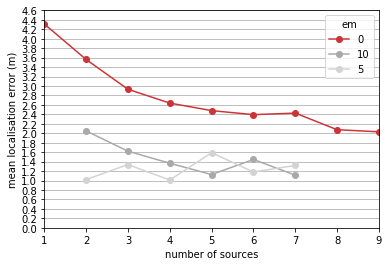

In [7]:
dfs = []
for desc in ['guessing-at-random', 'fixed-em-iterations-5', 'fixed-em-iterations-10']:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc)))
df = pd.concat(dfs)

dfp = df.pivot_table("err_mean", index="em", columns="n_sources", aggfunc='max').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
adjust_y_axis(0.2, 1, 0)